In [3]:
import cv2 as cv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from skimage import feature
import glob
from skimage.transform import rotate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold

Copying files: 351 files [19:03,  3.26s/ files]


### Membagi data train dan data testing

In [4]:
import splitfolders

# Menentukan folder awal dari dataset citra
base_dir = './Dataset/Original_Dataset'

# Melakukan split data berdasarkan ukuran 80% dan 20%
splitfolders.ratio(base_dir, output='./Dataset', seed=1337, ratio=(.8, .2))

Copying files: 5080 files [00:11, 426.83 files/s]


### Menentukan preproses dan scaling data

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Menentukan scalling dan perubahan setiap data train
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'wrap'
                )

# Menentukan scalling dan perubahan setiap data test
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'wrap'
                )

### Menerapkan citra dengan auto labeling berdasarkan nama folder

In [6]:
train_dir = './Dataset/train'
validation_dir = './Dataset/val'

train_generator = train_datagen.flow_from_directory(
        train_dir,  # Direktori data latih
        target_size=(150, 150),  # Mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir, # direktori data validasi
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=32,
        class_mode='categorical')

Found 4063 images belonging to 3 classes.
Found 1017 images belonging to 3 classes.


### Membuat Model CNN

In [7]:
import tensorflow as tf

# Conv2D --> Untuk mengaplikasikan filter pada citra
# MaxPooling2D --> Mengurangi resolusi gambar namun tetap ada informasi di gambar
# input_shape --> Sesuai dengan shape dari citra yang telah diubah dan diratakan sebelumnya

modelCNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2 ),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # Convert citra ke 1 dimensi
    tf.keras.layers.Flatten(),
    
    # Hidden layer
    # Terdapat 128 neuron di dalam 1 layer
    tf.keras.layers.Dense(128, activation='relu'),

    # Output layer dengan 3 output values
    # Disini 3 karena output kita (batu, gunting, kertas) --> softmax karena lebih dari 2 class
    tf.keras.layers.Dense(3, activation='softmax') 
])

### Compile Model

In [8]:
# categorical_crossentropy --> Digunakan untuk citra yang lebih dari 3 class
# tf.optimizers.Adam() --> Cocok untuk citra dengan data yang cukup banyak

modelCNN.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(), metrics=['accuracy'])

### Latih Model CNN

In [10]:
history = modelCNN.fit(
        train_generator,
        steps_per_epoch=40,  # Batch yang akan dieksekusi pada setiap epoch
        epochs=50,
        validation_data=validation_generator, # Menampilkan akurasi pengujian data validasi
        validation_steps=10, # Batch yang akan dieksekusi pada setiap epoch
        batch_size=100,
        verbose=1 # Animasi perjalanan epoch
      )

Epoch 1/50
40/40 [==============================] - 40s 995ms/step - loss: 0.1290 - accuracy: 0.9617 - val_loss: 0.3305 - val_accuracy: 0.8813
Epoch 2/50
40/40 [==============================] - 40s 1s/step - loss: 0.1106 - accuracy: 0.9586 - val_loss: 0.0908 - val_accuracy: 0.9688
Epoch 3/50
40/40 [==============================] - 40s 989ms/step - loss: 0.0768 - accuracy: 0.9727 - val_loss: 0.0694 - val_accuracy: 0.9750
Epoch 4/50
40/40 [==============================] - 40s 986ms/step - loss: 0.0601 - accuracy: 0.9828 - val_loss: 0.0685 - val_accuracy: 0.9688
Epoch 5/50
40/40 [==============================] - 40s 994ms/step - loss: 0.0553 - accuracy: 0.9859 - val_loss: 0.1170 - val_accuracy: 0.9563
Epoch 6/50
40/40 [==============================] - 40s 1s/step - loss: 0.0906 - accuracy: 0.9742 - val_loss: 0.1326 - val_accuracy: 0.9500
Epoch 7/50
40/40 [==============================] - 39s 981ms/step - loss: 0.0881 - accuracy: 0.9726 - val_loss: 0.0834 - val_accuracy: 0.9625
Epoch

### Model Summary

In [11]:
modelCNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

### Evaluate Model

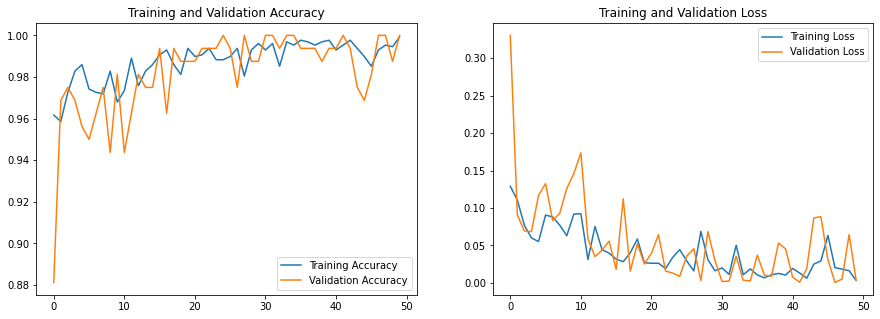

In [12]:
import matplotlib.pyplot as plt

# Akurasi
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Loss
loss = history.history['loss']
validation_loss = history.history['val_loss']

# Jumlah epoch
epochs_range = range(len(history.history['accuracy']))

# Plotting metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

### Testing Model

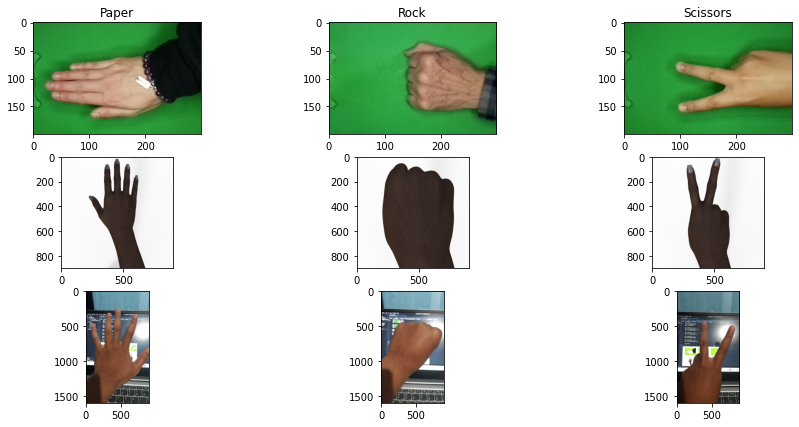

In [13]:
import matplotlib.pyplot as plt

# Backgroung hijau
img_paper_1 = plt.imread('./Dataset/Testing_Model/1fKclJk4eBWOQSR1.png')
img_rock_1 = plt.imread('./Dataset/Testing_Model/1mnAKQCHEDbtjPX2.png')
img_scissors_1 = plt.imread('./Dataset/Testing_Model/1L1n6plr7jlZGirw.png')

# Backgroung putih
img_paper_2 = plt.imread('./Dataset/Testing_Model/paper-hires1.png')
img_rock_2 = plt.imread('./Dataset/Testing_Model/rock-hires1.png')
img_scissors_2 = plt.imread('./Dataset/Testing_Model/scissors-hires1.png')

# Tangan sendiri
img_paper_3 = plt.imread('./Dataset/Testing_Model/paper-sendiri.jpeg')
img_rock_3 = plt.imread('./Dataset/Testing_Model/rock-sendiri.jpeg')
img_scissors_3 = plt.imread('./Dataset/Testing_Model/scissors-sendiri.jpeg')

plt.figure(figsize=(15, 7))

plt.subplot(3, 3, 1)
plt.imshow(img_paper_1)
plt.title('Paper')

plt.subplot(3, 3, 2)
plt.imshow(img_rock_1)
plt.title('Rock')

plt.subplot(3, 3, 3)
plt.imshow(img_scissors_1)
plt.title('Scissors')

plt.subplot(3, 3, 4)
plt.imshow(img_paper_2)

plt.subplot(3, 3, 5)
plt.imshow(img_rock_2)

plt.subplot(3, 3, 6)
plt.imshow(img_scissors_2)

plt.subplot(3, 3, 7)
plt.imshow(img_paper_3)

plt.subplot(3, 3, 8)
plt.imshow(img_rock_3)

plt.subplot(3, 3, 9)
plt.imshow(img_scissors_3)

plt.show()

In [14]:
import numpy as np
from tensorflow.keras.preprocessing import image

def convertImage(img) :
    gambar = image.load_img(img, target_size=(150, 150))
    gambar_array = image.img_to_array(gambar)
    gambar_batch = np.expand_dims(gambar_array, axis=0)
    gambar_preproses = np.vstack([gambar_batch])

    return gambar_preproses

In [15]:
# Backgroung hijau
img_paper_1 = './Dataset/Testing_Model/1fKclJk4eBWOQSR1.png'
img_rock_1 = './Dataset/Testing_Model/1mnAKQCHEDbtjPX2.png'
img_scissors_1 = './Dataset/Testing_Model/1L1n6plr7jlZGirw.png'

# Backgroung putih
img_paper_2 = './Dataset/Testing_Model/paper-hires1.png'
img_rock_2 = './Dataset/Testing_Model/rock-hires1.png'
img_scissors_2 = './Dataset/Testing_Model/scissors-hires1.png'

# Tangan sendiri
img_paper_3 = './Dataset/Testing_Model/paper-sendiri.jpeg'
img_rock_3 = './Dataset/Testing_Model/rock-sendiri.jpeg'
img_scissors_3 = './Dataset/Testing_Model/scissors-sendiri.jpeg'

prediction = modelCNN.predict(convertImage(img_scissors_2), batch_size=10)
output_class = np.argmax(prediction)

if output_class == 0:
    print('Paper')
elif output_class == 1:
    print('Rock')
else:
    print('Scissors')

Scissors
